In [2]:
import sys
sys.path.insert(0,'charsiu/src/')
from Charsiu import Wav2Vec2ForFrameClassification, CharsiuPreprocessor_en, charsiu_forced_aligner
import torch 
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/tomi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
from datasets import load_dataset

TIMIT = load_dataset('timit_asr', data_dir='/home/tomi/Documents/tesis_speechRate/timit')
TIMIT_train = TIMIT['train']
TIMIT_test = TIMIT['test']

sample = TIMIT_train[1]

Using the latest cached version of the module from /home/tomi/.cache/huggingface/modules/datasets_modules/datasets/timit_asr/43f9448dd5db58e95ee48a277f466481b151f112ea53e27f8173784da9254fb2 (last modified on Wed Apr  3 14:11:37 2024) since it couldn't be found locally at timit_asr, or remotely on the Hugging Face Hub.


In [4]:
# Line 1: Instantiate a forced aligner object from the 'charsiu' library using a specified model.
# 'aligner' specifies the model to be used for alignment, likely based on the Wav2Vec 2.0 model trained for frame classification every 10 milliseconds.
charsiu = charsiu_forced_aligner(aligner='charsiu/en_w2v2_fc_10ms')

# Line 2: Load a pre-trained model from Hugging Face's 'transformers' library.
# This model is likely a fine-tuned version of Wav2Vec 2.0 for the task of frame classification, useful for tasks like forced alignment or phoneme recognition.
modelo = Wav2Vec2ForFrameClassification.from_pretrained("charsiu/en_w2v2_fc_10ms")

# Line 3: Set the model to evaluation mode. This disables training specific behaviors like dropout, 
# ensuring the model's inference behavior is consistent and deterministic.
modelo.eval()

# Line 4: Instantiate a preprocessor for English from the 'charsiu' library.
# This object is likely used to prepare audio data by normalizing or applying necessary transformations 
# before it can be inputted to the model.
procesador = CharsiuPreprocessor_en()

# Line 5: Convert the audio data from a sample dictionary to a Torch tensor, necessary for processing with PyTorch models.
# 'np.array([sample['audio']['array']])' converts the audio samples to a NumPy array and wraps it in another array to add a batch dimension.
# '.astype(np.float32)' ensures that the data type is float32, which is typically required for neural network inputs in PyTorch.
x = torch.tensor(np.array([sample['audio']['array']]).astype(np.float32))

# Line 6: This line is inside a 'with' statement that disables gradient computation.
# 'torch.no_grad()' is crucial during inference to reduce memory consumption and speed up computations since backpropagation (gradient calculations) is not needed.
with torch.no_grad():
    # Line 7: Pass the preprocessed audio tensor 'x' through the model to obtain logits.
    # Logits are raw, non-normalized scores outputted by the last layer of a neural network. These need to be passed through a softmax layer to turn them into probabilities if necessary.
    y = modelo(x).logits


/home/tomi/.local/lib/python3.10/site-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/home/tomi/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at charsiu/en_w2v2_fc_10ms were not used when initializing Wav2Vec2ForFrameClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.

In [5]:
sample['audio']['array']

array([-3.05175781e-05,  0.00000000e+00,  3.05175781e-05, ...,
        9.15527344e-05,  3.05175781e-05, -6.10351562e-05])

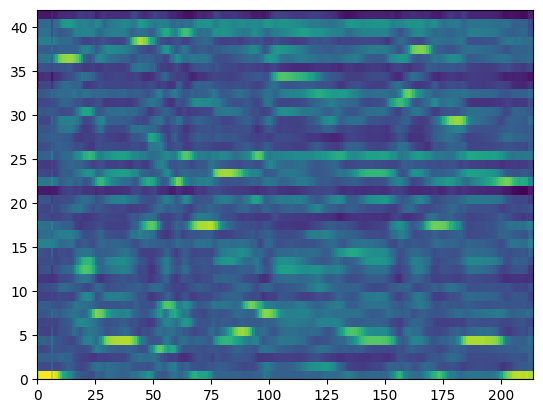

In [6]:
y = y.numpy()[0].T
plt.pcolor(y)

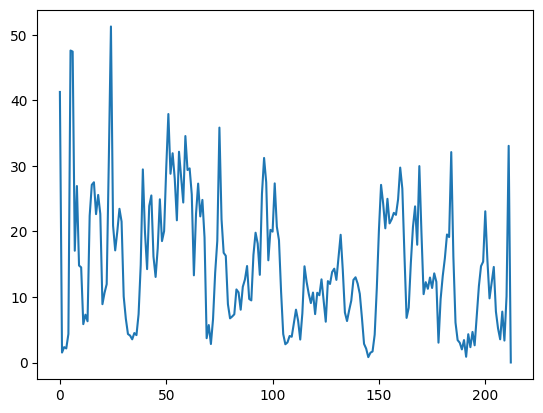

In [70]:
plt.plot(np.abs(np.diff(y)).sum(0))

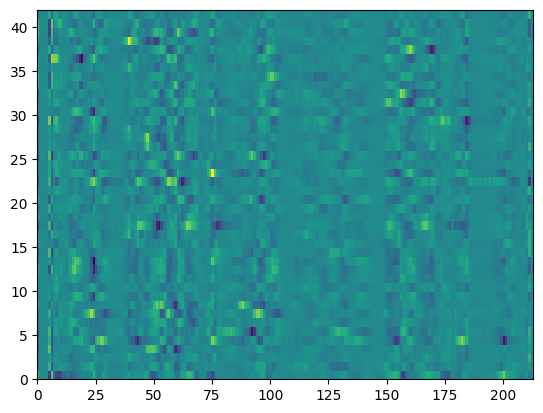

In [71]:
plt.pcolor(np.diff(y))

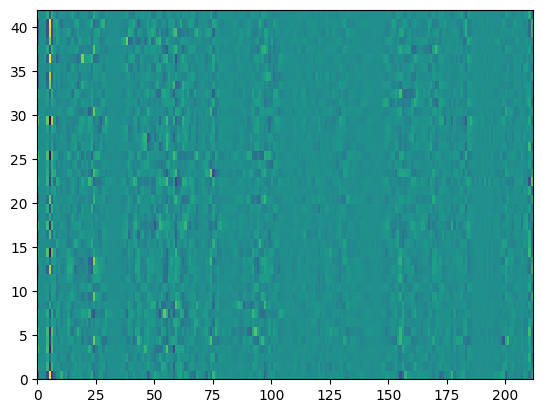

In [72]:
plt.pcolor(np.diff(np.diff(y)))

In [46]:
# 120 features aprox (charsiu, +delta, +ddelta)

# media, std, abs->media, abs->std

# 480 features

# regresion lineal -> phonerate promedio (con y sin pausas)


In [51]:
from pydub import AudioSegment

# Pydub uses milliseconds
flac_file_path = '../tesis_speechRate/audios_tomas/taran.flac'
flac_audio = AudioSegment.from_file(flac_file_path, format="flac")
print(flac_audio.duration_seconds)  # Outputs duration in seconds


2.403265306122449


In [50]:
flac_audio